In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# geopackages
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
from geospatial_functions import get_background_map
from geospatial_functions import reproject_raster
from geospatial_functions import remove_below_0

In [14]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'

# prepare data

Landsta data can be downlaoded from https://earthexplorer.usgs.gov/, using landsat 8 level 2 in this case. 

This data is unprocessed datset very large and thus is not included, the results will be included.

Analysis is done in QGIS with the [
Semi-Automatic Classification Plugin](https://github.com/semiautomaticgit/SemiAutomaticClassificationPlugin)

The data from landsat can be imported, merged into one multiband layer and clipped to the basin area. The bands are remaped as shown in the legend to make water more visible (black). _Note: not all areas area covered, but optted for best fit_

This result is shown below:

<!-- ![map_satelite_imaging](Figures\map_satelite_imaging.jpeg) -->
<img src="Figures\map_satelite_imaging.jpeg"
     alt="Figures\map_satelite_imaging.jpeg"
     width="600" 
     height="200" />

Then 10 sets for water and 10 for 'not water' are defined. These can then be used as training set for the algorithm. The result is the following raster:

In [3]:
# getting right colors
cmap = mpl.cm.get_cmap("winter")

# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   

# # fixing crs
# for layer in [outline,main_rivers,all_rivers]:
#     layer.geometry = layer.geometry.to_crs("EPSG:4326")

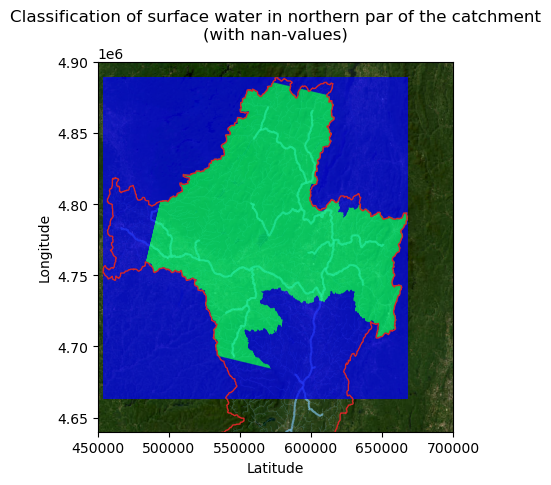

In [57]:
fig, ax = plt.subplots(1)
path = f'{gis_folder}\\classification_of_waterbodies_26918.tif'
with rasterio.open(path, driver='GTiff') as r:
        rioshow(r, ax=ax,cmap=cmap,alpha=0.7)

# add other features
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)

ax.set_title("Classification of surface water in northern par of the catchment\n(with nan-values)")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));


Remove the nan-values, in seperate py file 

In [6]:
fixed_nans_path = remove_below_0(f'{gis_folder}\\classification_of_waterbodies_26918.tif',ending="tif")

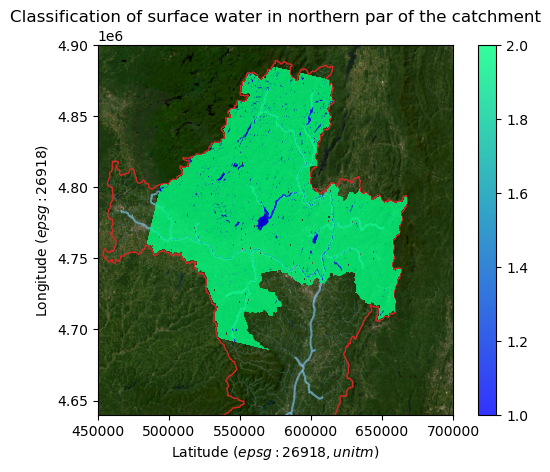

In [59]:
fig, ax = plt.subplots(1)
with rasterio.open(fixed_nans_path, driver='GTiff') as r:
        img = rioshow(r, ax=ax,cmap=cmap,zorder=100,alpha=0.8)
ax.set_title("Classification of surface water in northern par of the catchment")
ax.set_xlabel("Latitude $(epsg:26918, unit m)$")
ax.set_ylabel("Longitude $(epsg:26918)$")

# add other features
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

# add background
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-100)

# fix color bar
im = img.get_images()[0]
fig.colorbar(im,ax=ax,cmap=cmap);

ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

These can also be loaded in as polygons when transformed

In [60]:
df_all_water = gpd.read_file(f"{gis_folder}\\water_bodies_landsat_26918.gpkg")

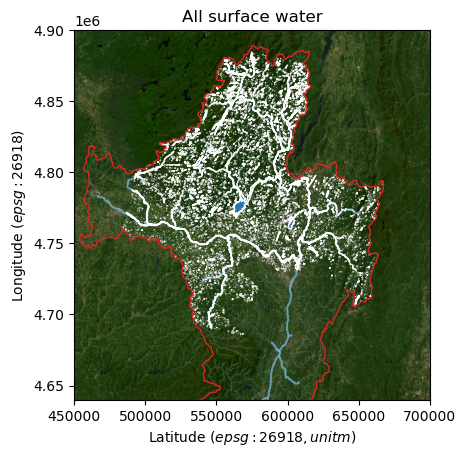

In [61]:
fig, ax  = plt.subplots(1)
df_all_water.plot(facecolor="C0",ax=ax,edgecolor="w")

# add other features
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

# add background
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-100)

ax.set_title("All surface water")
    
ax.set_xlabel("Latitude $(epsg:26918, unit m)$")
ax.set_ylabel("Longitude $(epsg:26918)$")

ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

In [62]:
print(f'total area of {df_all_water.area.sum()/10**6:.2f}km^2')

total area of 536.27km^2


notice some overlapt with rivers and some very small areas so these can be removed by only taking those larger than 10ha, the overlap remaining is merely the reservoirs built on the river rather than the actual course of the river. 

In [63]:
df_all_water_more10ha = gpd.read_file(f"{gis_folder}\\waterbodies_polygon_above10ha_excluding river.gpkg")

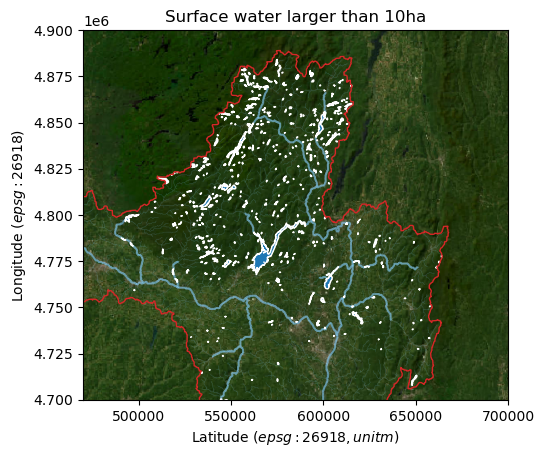

In [64]:
fig, ax  = plt.subplots(1)
df_all_water_more10ha.plot(facecolor="C0",ax=ax,edgecolor="w")

# add other features
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

# add background
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-100)
    
ax.set_title("Surface water larger than 10ha")

ax.set_xlabel("Latitude $(epsg:26918, unit m)$")
ax.set_ylabel("Longitude $(epsg:26918)$")    
    
ax.set_xlim((4.7e5,7e5))
ax.set_ylim((4.70e6,4.9e6));

In [65]:
print(f'total area of {df_all_water_more10ha.area.sum()/10**6:.2f}km^2')

total area of 371.26km^2
